In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random



import matplotlib.patches as patches
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from tqdm.notebook import trange,tqdm

In [ ]:
#Starting by loading the images from the pklot dataset
def load_images_only(path, img_ext='jpg'):
    # Check if the directory exists
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Directory not found: {path}")

    # List and filter image files
    imgs = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(img_ext)])

    if not imgs:
        raise ValueError(f"No image files with extension '{img_ext}' found in {path}.")

    return imgs

In [7]:


# Define all paths
train_path_images = r"C:\Users\deepa\Downloads\cpdetect\train\images"
train_path_labels = r"C:\Users\deepa\Downloads\cpdetect\train\labels"

test_path_images = r"C:\Users\deepa\Downloads\cpdetect\test\images"
test_path_labels = r"C:\Users\deepa\Downloads\cpdetect\test\labels"

valid_path_images = r"C:\Users\deepa\Downloads\cpdetect\valid\images"
valid_path_labels = r"C:\Users\deepa\Downloads\cpdetect\valid\labels"

# Load and print info
try:
    train_imgs = load_images_only(train_path_images)
    print(f"Loaded {len(train_imgs)} training images.")

    test_imgs = load_images_only(test_path_images)
    print(f"Loaded {len(test_imgs)} test images.")

    valid_imgs = load_images_only(valid_path_images)
    print(f"Loaded {len(valid_imgs)} validation images.")

    # Preview the first 5 from each
    print("\nSample Images:")
    print("Train:", train_imgs[:5])
    print("Test:", test_imgs[:5])
    print("Validation:", valid_imgs[:5])

except Exception as e:
    print(f"Error: {e}")


Loaded 8690 training images.
Loaded 1242 test images.
Loaded 2483 validation images.

Sample Images:
Train: ['C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_16_58_jpg.rf.f7c3a6a0a496da10a770916a11b6252c.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_27_08_jpg.rf.5e60cc857729128f0aa7bf474e45d780.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_29_29_jpg.rf.ac93794ed38c74c2b13cbaaae779081f.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_31_50_jpg.rf.cb6ca480f136df4312530bf22a970695.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_38_53_jpg.rf.7130913adc7448c26a3734b27093920d.jpg']
Test: ['C:\\Users\\deepa\\Downloads\\cpdetect\\test\\images\\2012-09-11_15_53_00_jpg.rf.8537f6252c0519cea23fa12293bbe52b.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\test\\images\\2012-09-11_16_48_36_jpg.rf.4214ff860ddaff96315462a5ed76ee93.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\

In [ ]:
# Print the first 15 image paths from each subset ( just for check )
print("First 5 train images: \n", train_imgs[:15])
print("First 5 test images: \n", test_imgs[:15])
print("First 5 validation images: \n", valid_imgs[:15])

First 5 train images: 
 ['C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_16_58_jpg.rf.f7c3a6a0a496da10a770916a11b6252c.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_27_08_jpg.rf.5e60cc857729128f0aa7bf474e45d780.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_29_29_jpg.rf.ac93794ed38c74c2b13cbaaae779081f.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_31_50_jpg.rf.cb6ca480f136df4312530bf22a970695.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_38_53_jpg.rf.7130913adc7448c26a3734b27093920d.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_43_35_jpg.rf.34a401cea819d2a62a2d1acdcef206f9.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_15_55_21_jpg.rf.b367eb05e53827461fdf89b6424604d0.jpg', 'C:\\Users\\deepa\\Downloads\\cpdetect\\train\\images\\2012-09-11_16_02_25_jpg.rf.c56d6928227c7b91266a3f9e696ce0e3.jpg', 'C:\\Us

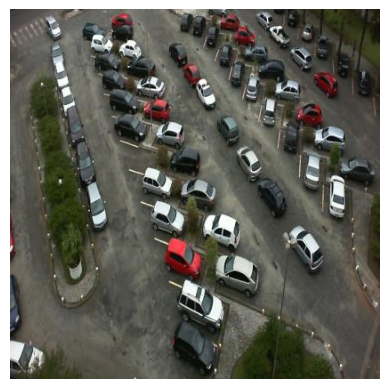

In [ ]:
# Load and display  an image aléatoire
n = random.randint(0, len(test_imgs) - 1)
img = Image.open(test_imgs[n])
plt.imshow(img)
plt.axis('off')
plt.show()

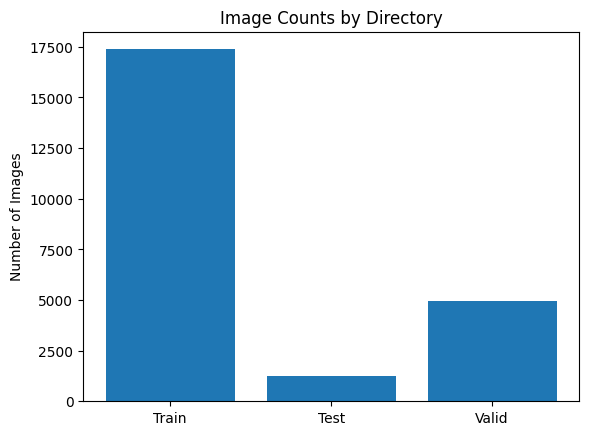

In [10]:
# Plot the number of images in each directory
# Get the number of images in each directory
train_count = len(os.listdir(train_path_images))
test_count = len(os.listdir(test_path_images))
valid_count = len(os.listdir(valid_path_images))

fig, ax = plt.subplots()
ax.bar(["Train", "Test","Valid"], [train_count, test_count ,valid_count])
ax.set_ylabel("Number of Images")
ax.set_title("Image Counts by Directory")
plt.show()

In [ ]:
def parse_label_file(label_file_path):
    labels = []
    try:
        with open(label_file_path, 'r') as file:
            for line in file:
                # Parse each line: class_id, x_center, y_center, width, height
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                labels.append((class_id, x_center, y_center, width, height))
    except FileNotFoundError:
        print(f"Label file not found: {label_file_path}")
    return labels

In [ ]:
def load_images_and_labels(image_path, label_path):
    data = []
    for image_file in os.listdir(image_path):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            image_full_path = os.path.join(image_path, image_file)
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_full_path = os.path.join(label_path, label_file)

            # Load image
            img = cv.imread(image_full_path)
            if img is None:
                continue

             # Parse labels
            labels = parse_label_file(label_full_path)
            # Determine binary label
            binary_label = 1 if any(label[0] == 1 for label in labels) else 0   #binary classification : 1 not empty , 0 is empty
            data.append((img, binary_label))
    return data

Loaded 1242 testing samples.


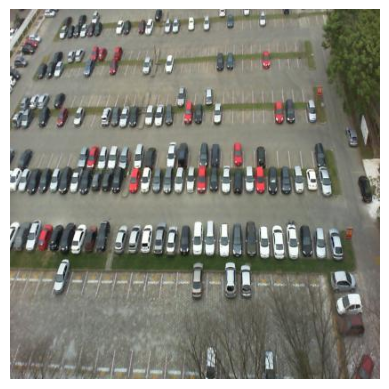

Image shape: (416, 416, 3)
Binary label: 1


In [13]:
# Load binary classification data
binary_train_data = load_images_and_labels(test_path_images, test_path_labels)
print(f"Loaded {len(binary_train_data)} testing samples.")

# Inspect one random sample
n = random.randint(0, len(test_imgs) - 1)

image, binary_label = binary_train_data[n]
img = Image.open(test_imgs[n])
plt.imshow(img)
plt.axis('off')
plt.show()
print("Image shape:", image.shape)
print("Binary label:", binary_label)

In [ ]:
import cv2 as cv

def process_image(image, bounding_boxes, method='shi_tomasi'):
    processed_slots = []

    height, width = image.shape[:2]

    for box in bounding_boxes:
        if len(box) != 5:
            print("Skipping invalid box:", box)
            continue

        class_id, x_center, y_center, w_norm, h_norm = map(float, box)

        # Convert normalized to pixel values
        x = int((x_center - w_norm / 2) * width)
        y = int((y_center - h_norm / 2) * height)
        w = int(w_norm * width)
        h = int(h_norm * height)

        # Clip coordinates to image bounds
        x = max(0, x)
        y = max(0, y)
        w = min(w, width - x)
        h = min(h, height - y)

        roi = image[y:y+h, x:x+w]

        if method == 'shi_tomasi':
            gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
            corners = cv.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
            if corners is not None:
                for corner in corners:
                    cx, cy = corner.ravel()
                    cv.circle(roi, (int(cx), int(cy)), 3, (0, 255, 0), -1)

        processed_slots.append(roi)

    return processed_slots



In [ ]:
# Function to process the dataset
def process_dataset(test_path_images, test_path_labels, method='shi_tomasi', visualize=False):

    # Load all image paths
    image_paths = load_images_only(test_path_images)

    for image_path in image_paths:
        # Load image
        image = cv.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Construct label file path
        label_file = os.path.splitext(os.path.basename(image_path))[0] + ".txt"
        label_path = os.path.join(test_path_labels, label_file)

        # Load bounding boxes from label file
        bounding_boxes = parse_label_file(label_path)

        # Process the image for each bounding box
        processed_slots = process_image(image, bounding_boxes, method)

        if visualize:
            # Visualize the processed slots
            for idx, slot in enumerate(processed_slots):
                plt.imshow(cv.cvtColor(slot, cv.COLOR_BGR2RGB))
                plt.title(f"Image: {os.path.basename(image_path)} | Slot {idx}")
                plt.show()

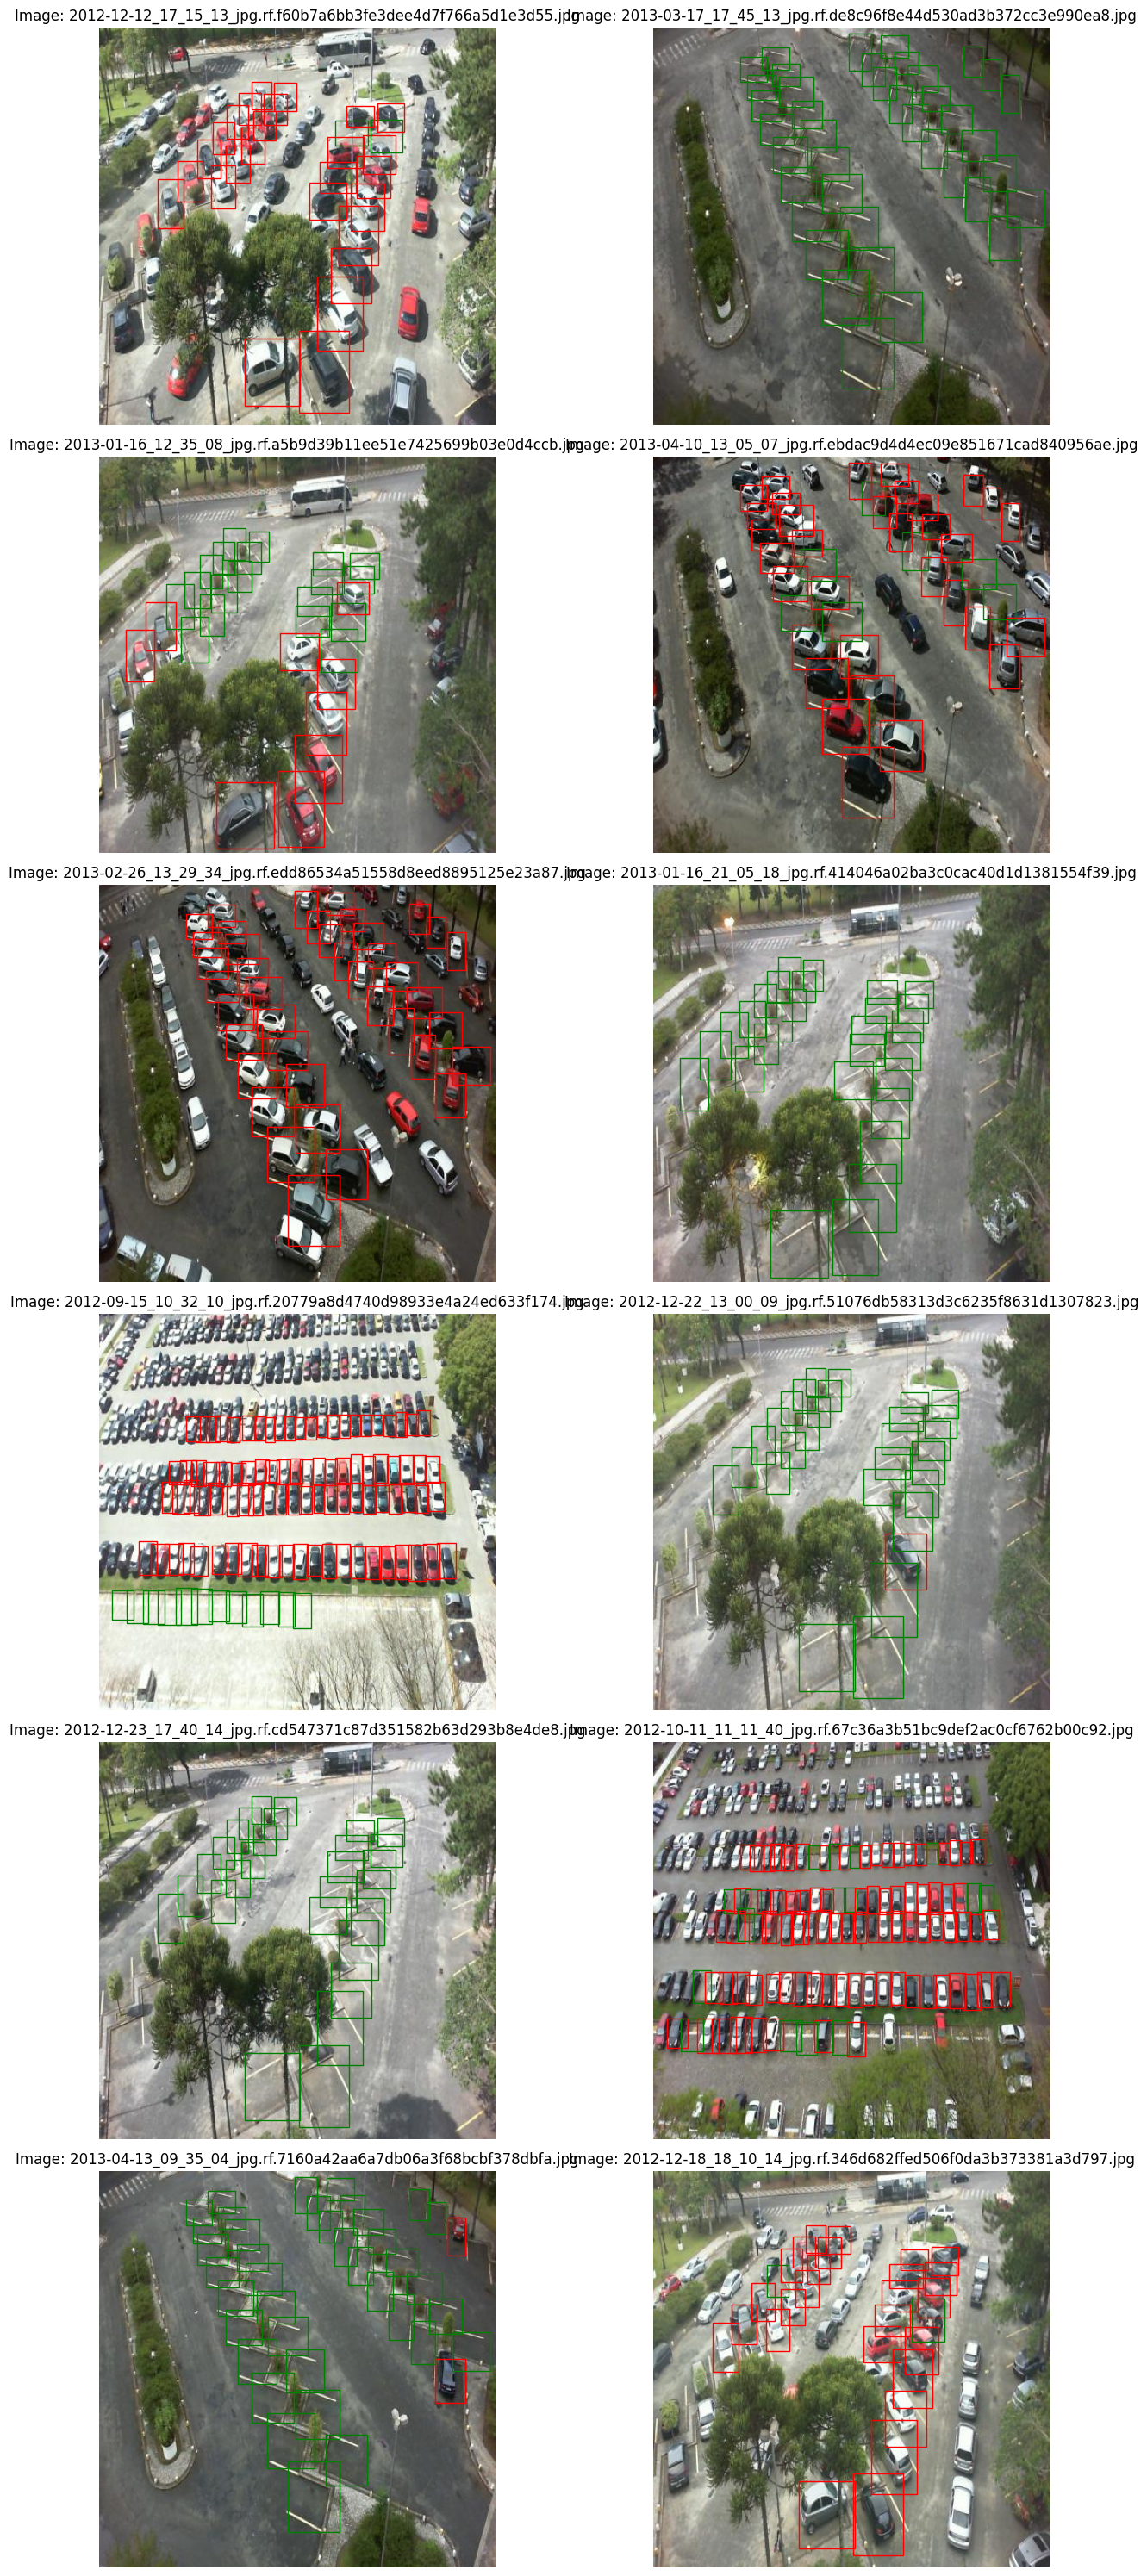

In [ ]:
# Load binary classification data (already loaded in previous cells, but showing here for context)
# binary_train_data = load_images_and_labels(test_path_images, test_path_labels)

# Load image and label paths for training data
train_img_paths = load_images_only(train_path_images)
# The parse_label_file function expects individual label file paths, not a directory.
# We need a list of label paths corresponding to the image paths.
train_label_paths = [os.path.join(train_path_labels, os.path.splitext(os.path.basename(img_path))[0] + ".txt") for img_path in train_img_paths]


def plot_images(images, labels_path, num_rows=6, num_cols=2, figsize=(15, 5*6), detection_type='none'):

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    # Ensure the number of random images to plot doesn't exceed the available images
    num_to_plot = min(len(axes), len(images))

    # Select random indices to display
    random_indices = np.random.choice(len(images), size=num_to_plot, replace=False)

    for i, ax_idx in enumerate(random_indices): # Iterate through random indices and their corresponding axes
        ax = axes[i] # Get the current axis from the flattened array

        # Use the random index to get the image and label paths
        img_path = images[ax_idx]
        label_path = labels_path[ax_idx]

        img = plt.imread(img_path)

        # We need to implement a function generate_target that can load boxes and labels from a label file path
        # Since this function was not provided in the context, we will create a placeholder
        # based on the assumed structure from the parse_label_file function output.
        # The original code was calling generate_target(idx, labels_path[idx]).values()
        # which implies generate_target takes an index and a *single* label path.
        # Given the `labels_path` is now a list of label paths, we will modify the call
        # to pass the *specific* label path for the chosen image.
        try:
            # Call a placeholder generate_target function (needs implementation)
            # This part needs to be adapted based on the actual structure and output
            # of the user's intended generate_target function.
            # For now, we'll simulate loading boxes and labels based on the parse_label_file output format.
            # The format from parse_label_file is (class_id, x_center, y_center, width, height)
            # The plot_images function expects boxes in (xmin, ymin, xmax, ymax) format and labels.
            # Let's create a dummy generate_target function that reads the labels
            # and converts them to the expected format.
            def generate_target(label_file_path, img_width, img_height):
                parsed_labels = parse_label_file(label_file_path)
                boxes = []
                labels = []
                # Convert normalized YOLO format (class_id, x_c, y_c, w, h) to (xmin, ymin, xmax, ymax)
                for class_id, x_center, y_center, width, height in parsed_labels:
                    xmin = (x_center - width / 2)
                    ymin = (y_center - height / 2)
                    xmax = (x_center + width / 2)
                    ymax = (y_center + height / 2)
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(class_id) # Assuming class_id is the label
                # Returning in a dictionary format as implied by the original call
                return {'boxes': torch.tensor(boxes, dtype=torch.float32),
                        'labels': torch.tensor(labels, dtype=torch.int64),
                        'image_id': torch.tensor([ax_idx])} # Dummy image_id


            # Now call the dummy generate_target with the correct label path and image dimensions
            # Get image dimensions after reading the image
            img_height, img_width = img.shape[:2]
            target = generate_target(label_path, img_width, img_height)
            boxes = target['boxes'].tolist() # Convert tensor to list for plotting
            labels = target['labels'].tolist() # Convert tensor to list for plotting


        except FileNotFoundError:
            print(f"Label file not found for image {img_path}: {label_path}")
            # Continue to the next image if label file is missing
            ax.imshow(img) # Display the image without bounding boxes
            ax.set_title(f"Image: {os.path.basename(img_path)} (Label missing)")
            ax.axis('off')
            continue # Skip plotting bounding boxes for this image
        except Exception as e:
            print(f"Error processing labels for image {img_path}: {e}")
            ax.imshow(img) # Display the image without bounding boxes
            ax.set_title(f"Image: {os.path.basename(img_path)} (Error loading labels)")
            ax.axis('off')
            continue # Skip plotting bounding boxes for this image


        if detection_type == 'edge':
            # Ensure the image is in a format that cv.Canny can handle (grayscale)
            if len(img.shape) == 3: # Check if it's a color image
                 img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            else:
                 img_gray = img # Assume it's already grayscale

            img = cv.Canny(np.uint8(img_gray), 50, 150)
            cmap = 'gray'
        elif detection_type == 'contour':
            # Ensure the image is in a format that cv.Canny and cv.findContours can handle
            img_contours = img.copy()
            if len(img.shape) == 3:
                img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            else:
                img_gray = img

            # Ensure img_gray is of the correct type for cv.Canny
            img_gray_uint8 = np.uint8(img_gray)

            contours, _ = cv.findContours(cv.Canny(img_gray_uint8, 50, 150),
                                           cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            # Convert the image to a format that cv.drawContours can draw on (e.g., BGR or RGB)
            if len(img_contours.shape) == 2: # If grayscale, convert to color for drawing colored contours
                 img_contours = cv.cvtColor(img_contours, cv.COLOR_GRAY2RGB)

            cv.drawContours(img_contours, contours, -1, (255, 255, 0), 1) # Draw in yellow
            img = img_contours
            cmap = 'viridis'
        else:
            cmap = 'viridis'
            if len(img.shape) == 2: # If the original image read was grayscale
                 img = cv.cvtColor(img, cv.COLOR_GRAY2RGB) # Convert to RGB for consistent display


        ax.imshow(img, cmap=cmap)
        ax.axis('off') # Turn off axes ticks and labels
        ax.set_title(f"Image: {os.path.basename(img_path)}") # Set title for each subplot


        for box, label in zip(boxes, labels):
            # Boxes are already normalized [xmin, ymin, xmax, ymax] from generate_target
            # We need to convert them back to pixel coordinates for plotting rectangles
            xmin, ymin, xmax, ymax = box
            xmin_pixel = xmin * img.shape[1]
            xmax_pixel = xmax * img.shape[1]
            ymin_pixel = ymin * img.shape[0]
            ymax_pixel = ymax * img.shape[0]

            # Calculate width and height for the rectangle
            width_pixel = xmax_pixel - xmin_pixel
            height_pixel = ymax_pixel - ymin_pixel

            if label == 1: # Assuming 1 represents 'occupied'
                rect = patches.Rectangle((xmin_pixel, ymin_pixel), width_pixel, height_pixel,
                                         linewidth=1, edgecolor='r', facecolor='none') # Red for occupied
            else: # Assuming 0 represents 'empty' or other classes
                rect = patches.Rectangle((xmin_pixel, ymin_pixel), width_pixel, height_pixel,
                                         linewidth=1, edgecolor='g', facecolor='none') # Green for empty/other

            ax.add_patch(rect)

    # Hide any unused subplots if num_to_plot is less than num_rows * num_cols
    for i in range(num_to_plot, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Now call plot_images with the lists of paths
plot_images(train_img_paths, train_label_paths)

In [ ]:
!pip install ultralytics



Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from ultralytics import YOLO

# Load a YOLOv8 model (e.g., medium size)
model = YOLO('yolov8m.pt')  

model.train(
    data=r"C:\Users\deepa\Downloads\cpdetect\data.yaml",
    epochs=30,
    imgsz=416,
    batch=16,
    cache='disk',
    name='pklot_yolov8m4',
    project='runs/train',  # keeps your training runs organized
    device=0,
    half=True,
    patience=10,
    save=True,
    save_period=1,
    workers=2
)


In [ ]:
results = model.predict(source=r'C:\Users\deepa\Downloads\cpdetect\train\images', save=True, conf=0.25)



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/8690 C:\Users\deepa\Downloads\cpdetect\train\images\2012-09-11_15_16_58_jpg.rf.f7c3a6a0a496da10a770916a11b6252c.jpg: 416x416 33 occupieds, 67 emptys, 94.8ms
image 2/8690 C:\Users\deepa\Downloads\cpdetect\train\images\2012-09-11_15_27_08_jpg.rf.5e60cc857729128f0aa7bf474e45d780.jpg: 416x416 33 occupieds, 68 emptys, 11.8ms
image 3/8690 C:\Users\deepa\Downloads\cpdetect\train\images\2012-09-11_15_29_29_jpg.rf.ac93794ed38c74c2b13cbaaae779081f.jpg: 416x

In [ ]:
from ultralytics import YOLO

# Load your trained model from the correct path
model = YOLO(r"C:\Users\deepa\Downloads\cpdetect\runs\train\pklot_yolov8m4\weights\best.pt")

# Run validation on the validation set you trained with
metrics = model.val()  

print(metrics)



Ultralytics 8.3.133  Python-3.12.4 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1.90.9 MB/s, size: 34.5 KB)


val: Scanning C:\Users\deepa\Downloads\cpdetect\valid\labels.cache... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [02:14<00:00,  1.16it/s]


                   all       2483     143316      0.999      0.999      0.995      0.994
              occupied       2062      73629      0.999      0.998      0.995      0.994
                 empty       1967      69687      0.999      0.999      0.995      0.993
Speed: 0.3ms preprocess, 20.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000236AED2D7F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,  

In [4]:
from ultralytics import YOLO
import pandas as pd
from pathlib import Path
import os

# Load your trained model
model = YOLO(r"C:\Users\deepa\Downloads\cpdetect\runs\train\pklot_yolov8m4\weights\best.pt")

# Folder with all test images
test_folder = r"C:\Users\deepa\Downloads\cpdetect\test\images"

# Prepare results list
results_list = []

# Loop through each image in test folder
for filename in os.listdir(test_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(test_folder, filename)

        # Predict
        results = model.predict(source=image_path, save=False, conf=0.25)

        occupied = 0
        empty = 0

        for result in results:
            for cls in result.boxes.cls:
                class_id = int(cls.item())
                if class_id == 0:  # Assuming 0 = empty
                    empty += 1
                elif class_id == 1:  # Assuming 1 = occupied
                    occupied += 1

        total = occupied + empty

        # Add to results list
        results_list.append({
            "Image Name": filename,
            "Total Slots": total,
            "Occupied Slots": occupied,
            "Available Slots": empty
        })

# Convert to DataFrame
df = pd.DataFrame(results_list)

# Save to CSV
output_csv = Path("dataset_slot_summary.csv")
df.to_csv(output_csv, index=False)

print(f"✅ Whole dataset analysis saved as: {output_csv.resolve()}")
print(df.head())



image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_15_53_00_jpg.rf.8537f6252c0519cea23fa12293bbe52b.jpg: 416x416 29 occupieds, 71 emptys, 21.1ms
Speed: 1.1ms preprocess, 21.1ms inference, 7.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_16_48_36_jpg.rf.4214ff860ddaff96315462a5ed76ee93.jpg: 416x416 25 occupieds, 75 emptys, 26.3ms
Speed: 1.9ms preprocess, 26.3ms inference, 6.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_06_36_36_jpg.rf.007cfe9ae01356b41e81396d5bc3ce19.jpg: 416x416 100 occupieds, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_08_15_53_jpg.rf.b47e91dfcd3e26394c37a87ede458d97.jpg: 416x416 7 occupieds, 93 emptys, 23.6ms
Speed: 1.8ms preprocess, 23.6ms inference, 5.1ms postprocess per image a

In [22]:
import os
from PIL import Image
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms as T
from ultralytics import YOLO
import cv2
import numpy as np


In [ ]:
# Your dataset path
input_folder = r"C:\Users\deepa\Downloads\cpdetect\test\images"
output_folder = r"C:\Users\deepa\Downloads\cpdetect\fusion_output"
os.makedirs(output_folder, exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png"))]


In [27]:
def mask_predict(img):
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = mask_model(img_tensor)[0]
    return predictions

def fuse_predictions(img_path):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Get Mask R-CNN results
    mask_preds = mask_predict(img)
    
    # Draw masks from Mask R-CNN
    for mask in mask_preds["masks"]:
        mask_np = mask[0].mul(255).byte().cpu().numpy()
        img_cv2[mask_np > 127] = (0, 255, 0)  # Overlay green for mask

    # YOLO inference
    yolo_results = yolo_model(img_path)
    yolo_annotated = yolo_results[0].plot()
    
    # Resize YOLO result to match mask-blended image size
    fused = cv2.addWeighted(img_cv2, 0.6, yolo_annotated, 0.4, 0)

    return fused


In [28]:
for image_file in image_files:
    img_path = os.path.join(input_folder, image_file)
    fused_img = fuse_predictions(img_path)
    
    save_path = os.path.join(output_folder, image_file)
    cv2.imwrite(save_path, fused_img)



image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_15_53_00_jpg.rf.8537f6252c0519cea23fa12293bbe52b.jpg: 416x416 29 occupieds, 71 emptys, 17.4ms
Speed: 0.9ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_16_48_36_jpg.rf.4214ff860ddaff96315462a5ed76ee93.jpg: 416x416 25 occupieds, 75 emptys, 17.8ms
Speed: 1.0ms preprocess, 17.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_06_36_36_jpg.rf.007cfe9ae01356b41e81396d5bc3ce19.jpg: 416x416 100 occupieds, 18.7ms
Speed: 0.8ms preprocess, 18.7ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_08_15_53_jpg.rf.b47e91dfcd3e26394c37a87ede458d97.jpg: 416x416 7 occupieds, 93 emptys, 17.4ms
Speed: 1.2ms preprocess, 17.4ms inference, 1.9ms postprocess per image a

In [29]:
import os
import cv2
import csv
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Paths
input_folder = r"C:\Users\deepa\Downloads\cpdetect\test\images"
output_folder = r"C:\Users\deepa\Downloads\cpdetect\fusion_output"
csv_output_path = os.path.join(output_folder, "slot_summary.csv")
os.makedirs(output_folder, exist_ok=True)

# Device and transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])

# Placeholder for your models
# yolo_model = ...
# mask_model = ...

# Image files
image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png"))]

def mask_predict(img):
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = mask_model(img_tensor)[0]
    return predictions

def fuse_predictions(img_path):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Mask R-CNN (detect slots)
    mask_preds = mask_predict(img)
    masks = mask_preds["masks"]  # shape: [N, 1, H, W]
    total_slots = masks.shape[0]
    
    # Prepare mask bounding boxes
    slot_boxes = mask_preds["boxes"].cpu().numpy()

    # YOLOv8 inference (detect vehicles)
    yolo_results = yolo_model(img_path)
    yolo_boxes = yolo_results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    
    occupied = 0
    for slot_box in slot_boxes:
        x1, y1, x2, y2 = slot_box.astype(int)
        slot_center = [(x1 + x2) // 2, (y1 + y2) // 2]

        for vehicle_box in yolo_boxes:
            vx1, vy1, vx2, vy2 = vehicle_box.astype(int)
            if vx1 <= slot_center[0] <= vx2 and vy1 <= slot_center[1] <= vy2:
                occupied += 1
                break

    available = total_slots - occupied

    # Draw slot masks
    for mask in masks:
        mask_np = mask[0].mul(255).byte().cpu().numpy()
        img_cv2[mask_np > 127] = (0, 255, 0)

    # Overlay YOLO detections
    yolo_annotated = yolo_results[0].plot()
    fused = cv2.addWeighted(img_cv2, 0.6, yolo_annotated, 0.4, 0)

    return fused, total_slots, occupied, available

# Results list for CSV
csv_rows = [["Image", "Total Slots", "Occupied Slots", "Available Slots"]]

# Process each image
for image_file in image_files:
    img_path = os.path.join(input_folder, image_file)
    fused_img, total, occ, avail = fuse_predictions(img_path)
    
    # Save image
    save_path = os.path.join(output_folder, image_file)
    cv2.imwrite(save_path, fused_img)
    
    # Append to CSV rows
    csv_rows.append([image_file, total, occ, avail])

# Write CSV file
with open(csv_output_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

print(f"CSV saved at: {csv_output_path}")



image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_15_53_00_jpg.rf.8537f6252c0519cea23fa12293bbe52b.jpg: 416x416 29 occupieds, 71 emptys, 17.4ms
Speed: 0.8ms preprocess, 17.4ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-11_16_48_36_jpg.rf.4214ff860ddaff96315462a5ed76ee93.jpg: 416x416 25 occupieds, 75 emptys, 17.9ms
Speed: 0.7ms preprocess, 17.9ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_06_36_36_jpg.rf.007cfe9ae01356b41e81396d5bc3ce19.jpg: 416x416 100 occupieds, 18.7ms
Speed: 1.0ms preprocess, 18.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\deepa\Downloads\cpdetect\test\images\2012-09-12_08_15_53_jpg.rf.b47e91dfcd3e26394c37a87ede458d97.jpg: 416x416 7 occupieds, 93 emptys, 18.4ms
Speed: 0.7ms preprocess, 18.4ms inference, 1.8ms postprocess per image a

In [ ]:
model.export(format='onnx')  # other formats: 'tflite', 'torchscript', 'coreml'


In [2]:
pip install streamlit opencv-python ultralytics pandas


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.9 MB 1.5 MB/s eta 0:00:07
   ---- ----------------------------------- 1.0/9.9 MB 1.7 MB/s eta 0:00:06
   ----- ---------------------------------- 1.3/9.9 MB 1.6 MB/s eta 0:00:06
   ------ --------------------------------- 1.6/9.9 MB 1.6 MB/s eta 0:00:06
   ------- -------------------------------- 1.8/9.9 MB 1.5 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/9.9 MB 1.6 MB/s eta 0:00:05
   ---------- ----------------------------- 2.6/9.9 MB 1.6 MB/s eta 0:00:05
   ------------ --------------------------- 3.1/9.9 MB 1.7 MB/s eta 0:00:05
   ------------- -------------------------- 3.4/9.9 MB 1.7 MB/s eta 0:00:04
   --------------- ------------------------ 3.9/9.9 MB 1.7 MB/s eta 0:00:04
   ----------------- ---